In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

In [4]:
repo_url = "https://github.com/aakashvardhan/s22-unet-vae.git"

local_dir = '/content/s22-unet-vae'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

Cloning into 's22-unet-vae'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 133 (delta 58), reused 117 (delta 42), pack-reused 0
Receiving objects: 100% (133/133), 54.45 KiB | 4.54 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [5]:
%cd s22-unet-vae

/content/s22-unet-vae


In [6]:
import sys

sys.path.append('.')
sys.path.append('./models')
sys.path.append('./data')
sys.path.append('./notebooks')
sys.path.append('./utils')

In [7]:
!pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 77.4 MB/s eta 0:00:00


In [8]:
from lightning.pytorch import Trainer, seed_everything
import lightning as pl
from lightning.pytorch.callbacks import (ModelCheckpoint,
                                         LearningRateMonitor,
                                         RichModelSummary,
                                         EarlyStopping)
from config import UNetConfig, load_config, update_config
import torch
import os
from lit_unet import LitUNet
from datamodule import DataModule
from callbacks import ClassAccuracyLoss, PlotExampleCallback
import wandb
from lightning.pytorch.loggers import WandbLogger

os.environ["WANDB_NOTEBOOK_NAME"] = "./notebooks/train-unet-model-1.ipynb"
wandb.init(settings=wandb.Settings(_service_wait=300))

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
torch.cuda.empty_cache()
pl.seed_everything(42, workers=True)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

In [10]:
config = UNetConfig()
json_data = load_config("training_1.json")
config = update_config(config, json_data)
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=16, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [11]:
config.batch_size = 32
print(config)

UNetConfig(in_channels=3, out_channels=3, num_filters=64, num_layers=4, batch_size=32, learning_rate=0.001, epochs=25, root_dir='./data', height=240, width=240, optimizer='adam', loss_function='cross_entropy', channel_reduction_method='max_pool', channel_expansion_method='conv_transpose', softmax_dim=1, dropout_rate=0.5, augmentation=True)


In [12]:
# initialise the wandb logger and name your wandb project
wandb_logger = WandbLogger(project='s22-unet')

# add your batch size to the wandb config
wandb_logger.experiment.config["batch_size"] = config.batch_size

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [13]:
data_module = DataModule(config)
data_module.setup()

100%|██████████| 791918971/791918971 [00:29<00:00, 26956042.82it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11319887.93it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [14]:
model = LitUNet(config)

In [15]:
callback = [ModelCheckpoint(dirpath="checkpoints/",
                                                         save_top_k=3,
                                                         monitor="val_loss",
                                                         mode="min",
                                                         filename="model-{epoch:02d}-{val_loss:.2f}-{val_loss:4f}",
                                                         save_last=True,
                                                         verbose=True,),
                              ClassAccuracyLoss(),
                              LearningRateMonitor(logging_interval='step', log_momentum=True)]

In [16]:
trainer = pl.Trainer(precision="16-mixed",
                     max_epochs= config.epochs,
                     accelerator="cuda",
                     devices="auto",
                     logger = wandb_logger,
                     callbacks=callback,
                    check_val_every_n_epoch=3,
                    num_sanity_val_steps=2)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Finding best initial lr:   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO: `Trainer.fit` stopped: `max_steps=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=25` reached.
ERROR: Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the s

new_lr=None


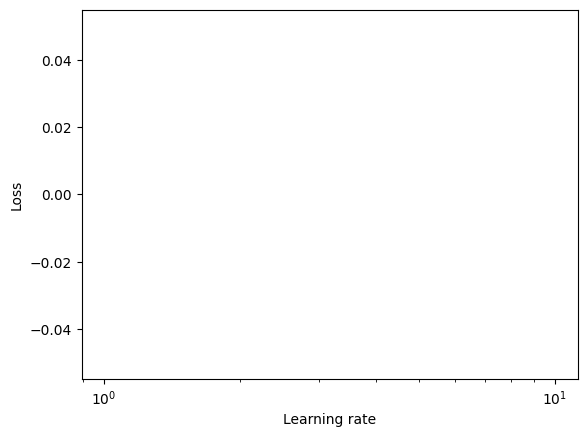

In [17]:
from lightning.pytorch.tuner import Tuner

# Create a Tuner
tuner = Tuner(trainer)

# Finding the learning rate
lr_finder =tuner.lr_find(model,datamodule=data_module, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs,attr_name='learning_rate')

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [ ]:
new_lr = model.learning_rate